In [20]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain
import igraph as ig
import leidenalg as la
from array import *

from sklearn.cluster import KMeans
from node2vec import Node2Vec as n2v
sns.set()


In [7]:
import igraph as ig
import leidenalg as la
from array import *

In [21]:
def array_list(array_num):
    num_list = [] # list
    # Iterating over the array
    for i in array_num:
        num_list.append(i)
   
    return(num_list)


def convert(nparray):
    a = []
    for i in nparray:
        a.append(str(i))
    return(a)

1005


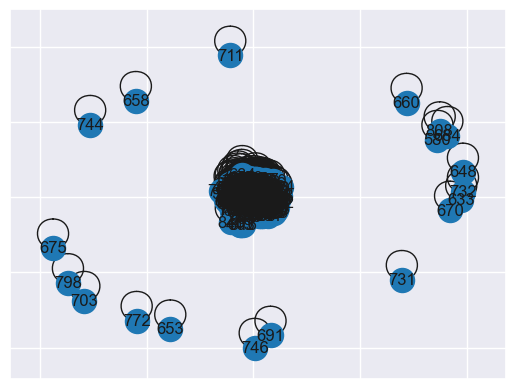

In [32]:
#Lots of possible graphs to use as a test of the implentation

#https://snap.stanford.edu/data/email-Eu-core.html --> "using email data from a large European research institution" -- 1005 nodes
f = open('email-Eu-core.edgelist', 'r')
G = nx.read_edgelist(f, create_using = nx.Graph())
G = nx.convert_node_labels_to_integers(G)
g1 = ig.Graph.Read_Ncol('email-Eu-core.edgelist')

#email stores the values inherintly as strings


#Possibility to draw the network

nx.draw_networkx(G)
# g1 = ig.Graph(len(G), list(zip(*list(zip(*nx.to_edgelist(G)))[:2])))


#The Classic Karate Club


# G = nx.karate_club_graph()
# g1 = ig.Graph.Famous('Zachary')


#https://snap.stanford.edu/data/ego-Twitter.html --> "Twitter data was crawled from public sources" -- 81306 nodes
# f = open('twitter_combined.txt', 'r')
# G = nx.read_edgelist(f, create_using = nx.Graph())
# G = nx.convert_node_labels_to_integers(G)
# g1 = ig.Graph.Read_Ncol('twitter_combined.txt')



In [30]:
# node2vec


    
#     Uses the node2vec implementation: https://github.com/eliorc/node2vec

#     Input:
#         WINDOW: Window size to use in Word2Vec. Same as used in gensim word2vec
            
#         MIN_COUNT: Only include nodes that are visited more than this number of times. 
#             Same as used in gensim word2vec
            
#         BATCH_WORDS: Number of words to feed into processing. Same as used in gensim word2vec
            
#         DIMENSIONS: dimension of embedding space
            
#         G = Graph in networkx
        
#     Output:
        
#         An array with vectors of each notes
        

pq = [[0.2, 0.25, 0.4], [0.25,0.5, 0.75, 1]]       


def node2vec(p, q, WINDOW = 10, MIN_COUNT = 2, BATCH_WORDS = 4, DIMENSIONS = 128, G= G):  
    WINDOW = 10 # Node2Vec fit window
    MIN_COUNT = 2 # Node2Vec min. count
    BATCH_WORDS = 4 # Node2Vec batch words
    #Consider changing the dimensions
    
    g_emb = n2v(
      G,
      dimensions=DIMENSIONS,
        p=p,
        q=q,
        workers = 4
    )

    mdl = g_emb.fit(
        window=WINDOW,
        min_count=MIN_COUNT,
        sg = 1
    )

    emb_df = (
        pd.DataFrame(
            [mdl.wv.get_vector(str(n)) for n in G.nodes()],
            index = G.nodes
        )
    )
    return emb_df.values


n_clusters = 100


# mod_n2v:

#     Input:
#         G = graph to use in networkx
#         g1 = graph to use in igraph
#         n_clusters = number of clusters to use for Kmeans clustering
#         prt: True if you want function to print out modularity of e_leiden, 
#              False if you want it to return
#     
#     Output: Either print statement or value of e_leiden
#         May alter the output by commenting out appropriate lines

def mod_n2v(X, G = G, g1 = g1, n_clusters = n_clusters, prt = True):
    clustering = KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 'auto').fit(X)
    communities = [np.where(clustering.labels_ == i)[0] for i in range(n_clusters)]
    dict_communities = {i: clustering.labels_[i] for i in range(len(clustering.labels_))}
    n2v_modularity = nx.community.modularity(G, communities)
    e_louvain = community_louvain.best_partition(G, partition = dict_communities)
    e_leiden = la.find_partition(graph = g1, initial_membership = clustering.labels_, partition_type = la.ModularityVertexPartition, 
                             n_iterations = -1)
#     print(f'Modularity for n2v: {n2v_modularity}')
    if prt == False:
        return g1.modularity(e_leiden)
    else:
        print(f'Modularity for n2v-leiden  = {g1.modularity(e_leiden)}')
#     print(f'Modularity for n2v - louvain: {community_louvain.modularity(e_louvain, G)}')


def pq_plot(p,q):
    X = node2vec(p,q)
    return np.array([mod_n2v(n_clusters =i, prt = False, X = X) for i in x])

In [24]:
data = np.zeros((4,4))

In [ ]:
X = node2vec(p=0.25, q=1)
# print(clustering.labels_)
# print(np.where(clustering.labels_ == 4)[0])

In [27]:
louvain_communities = nx.community.louvain_communities(G)
# print(f'Modularity for louvain  = {nx.community.modularity(G, louvain_communities)}')


leiden = la.find_partition(graph = g1, partition_type = la.ModularityVertexPartition, n_iterations = -1)


# for n in np.linspace(len(G.nodes)/2, len(G.nodes)/1.1 , num =10, dtype = 'int32'):
#     print('Nclusters:', n )
#     mod_n2v(n_clusters =n, X = X)

Generating walks (CPU: 2): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


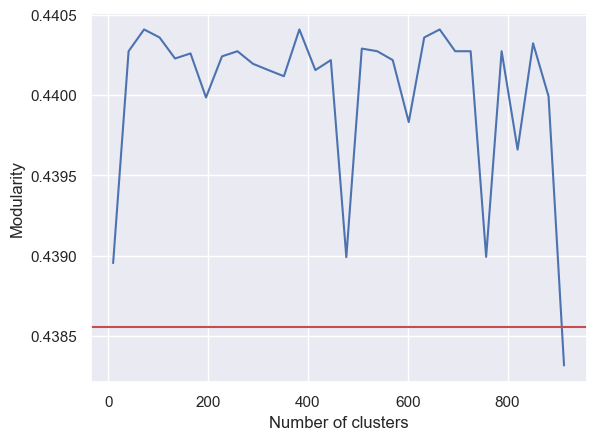

In [28]:
#Plot to see optimim number of clusters for Kmeans:
fig, ax = plt.subplots()
x = np.linspace(10, len(G.nodes)/1.1 , num =30, dtype = 'int32')
ax.plot(x, np.array([mod_n2v(n_clusters =i, prt = False, X = X) for i in x]))
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Modularity')
plt.axhline(y = g1.modularity(leiden), color = 'r', linestyle = '-')

Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


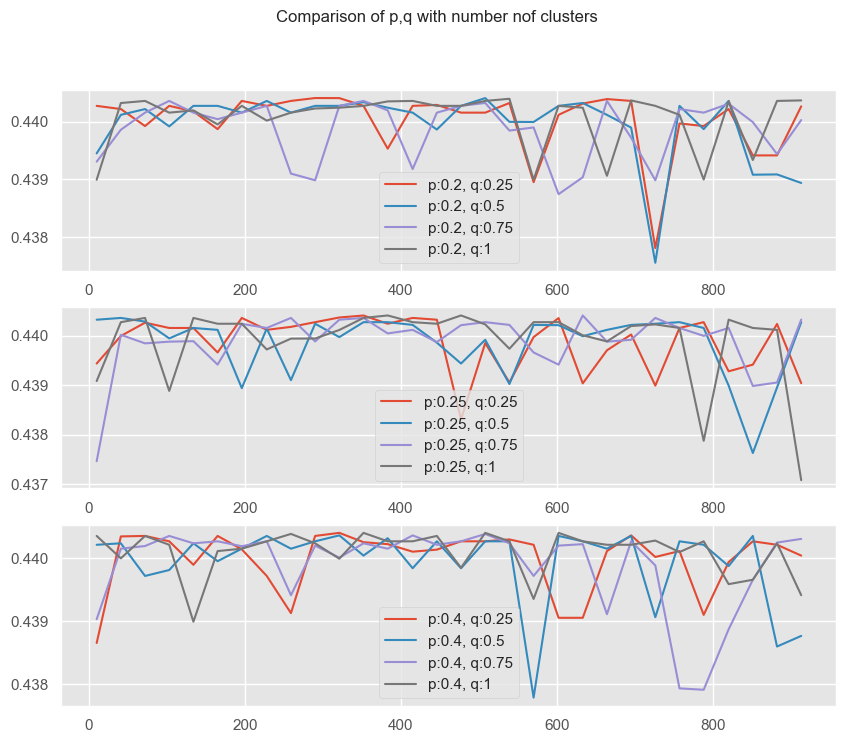

In [26]:
fig,axs = plt.subplots(len(pq[0]), figsize = (10,8))
x = np.linspace(10, len(G.nodes)/1.1 , num =30, dtype = 'int32')
fig.suptitle('Comparison of p,q with number nof clusters')
plt.style.use('ggplot')
for i in range(len(pq[0])):
    for j in range(len(pq[1])):
        axs[i].plot(x, pq_plot(pq[0][i], pq[1][j]), label = f'p:{pq[0][i]}, q:{pq[1][j]}')
    axs[i].legend()
# plt.savefig(fname = 'pq comparison', dpi = 400)